In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))

Numerical features: 296
Categorical features: 5


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 368
Categorical Columns: 5


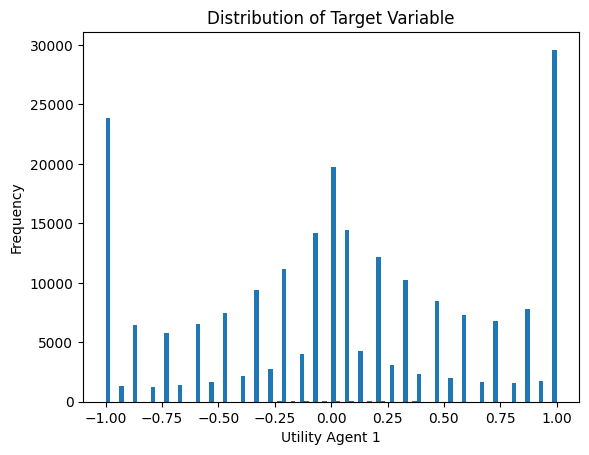

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [6]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [7]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 7,
        'learning_rate': 0.1,
        'alpha': 0.1,  # Equivalent to reg_alpha in LightGBM
        'lambda': 0.1,  # Equivalent to reg_lambda in LightGBM
        'colsample_bytree': 0.8,  # Equivalent to feature_fraction in LightGBM
        'seed': 2112,
        'verbosity': 0,  # Equivalent to verbose: -1 in LightGBM
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=2000,
            evals=[(val_data, 'val')],
            verbose_eval=25,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [8]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_csv(path_results / 'oof_xgboost_cv1.csv', index=False)
# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_xgboost_cv1.csv', index=False)


Fold 1


[0]	val-rmse:0.54811


[25]	val-rmse:0.48561


[50]	val-rmse:0.47134


[75]	val-rmse:0.46443


[100]	val-rmse:0.46103


[125]	val-rmse:0.45548


[150]	val-rmse:0.45220


[175]	val-rmse:0.44976


[200]	val-rmse:0.44850


[225]	val-rmse:0.44741


[250]	val-rmse:0.44673


[275]	val-rmse:0.44573


[300]	val-rmse:0.44559


[325]	val-rmse:0.44512


[350]	val-rmse:0.44474


[375]	val-rmse:0.44424


[400]	val-rmse:0.44376


[425]	val-rmse:0.44364


[450]	val-rmse:0.44358


[475]	val-rmse:0.44337


[500]	val-rmse:0.44335


[525]	val-rmse:0.44319


[550]	val-rmse:0.44332


[575]	val-rmse:0.44347


[600]	val-rmse:0.44351


[625]	val-rmse:0.44366


[650]	val-rmse:0.44374


[675]	val-rmse:0.44381


[700]	val-rmse:0.44386


[725]	val-rmse:0.44399


[750]	val-rmse:0.44397


[775]	val-rmse:0.44408


[800]	val-rmse:0.44412


[825]	val-rmse:0.44423


[850]	val-rmse:0.44427


[875]	val-rmse:0.44411


[900]	val-rmse:0.44416


[925]	val-rmse:0.44436


[950]	val-rmse:0.44442


[975]	val-rmse:0.44428


[1000]	val-rmse:0.44429


[1025]	val-rmse:0.44433


[1050]	val-rmse:0.44432


[1075]	val-rmse:0.44433


[1100]	val-rmse:0.44445


[1125]	val-rmse:0.44443


[1150]	val-rmse:0.44445


[1175]	val-rmse:0.44448


[1200]	val-rmse:0.44459


[1225]	val-rmse:0.44463


[1250]	val-rmse:0.44461


[1275]	val-rmse:0.44464


[1300]	val-rmse:0.44469


[1325]	val-rmse:0.44468


[1350]	val-rmse:0.44470


[1375]	val-rmse:0.44477


[1400]	val-rmse:0.44480


[1425]	val-rmse:0.44481


[1450]	val-rmse:0.44491


[1475]	val-rmse:0.44493


[1500]	val-rmse:0.44490


[1525]	val-rmse:0.44499


[1550]	val-rmse:0.44505


[1575]	val-rmse:0.44511


[1600]	val-rmse:0.44511


[1625]	val-rmse:0.44520


[1650]	val-rmse:0.44528


[1675]	val-rmse:0.44530


[1700]	val-rmse:0.44535


[1725]	val-rmse:0.44541


[1750]	val-rmse:0.44540


[1775]	val-rmse:0.44544


[1800]	val-rmse:0.44547


[1825]	val-rmse:0.44550


[1850]	val-rmse:0.44551


[1875]	val-rmse:0.44553


[1900]	val-rmse:0.44557


[1925]	val-rmse:0.44561


[1950]	val-rmse:0.44566


[1975]	val-rmse:0.44573


[1999]	val-rmse:0.44581


Fold 1 - RMSE: 0.4449881607660023
Fold 2


[0]	val-rmse:0.57584


[25]	val-rmse:0.49677


[50]	val-rmse:0.48418


[75]	val-rmse:0.48070


[100]	val-rmse:0.47729


[125]	val-rmse:0.47391


[150]	val-rmse:0.47012


[175]	val-rmse:0.46712


[200]	val-rmse:0.46488


[225]	val-rmse:0.46412


[250]	val-rmse:0.46345


[275]	val-rmse:0.46234


[300]	val-rmse:0.46147


[325]	val-rmse:0.46098


[350]	val-rmse:0.46015


[375]	val-rmse:0.45994


[400]	val-rmse:0.45923


[425]	val-rmse:0.45909


[450]	val-rmse:0.45873


[475]	val-rmse:0.45855


[500]	val-rmse:0.45870


[525]	val-rmse:0.45854


[550]	val-rmse:0.45818


[575]	val-rmse:0.45829


[600]	val-rmse:0.45799


[625]	val-rmse:0.45796


[650]	val-rmse:0.45806


[675]	val-rmse:0.45805


[700]	val-rmse:0.45786


[725]	val-rmse:0.45773


[750]	val-rmse:0.45765


[775]	val-rmse:0.45765


[800]	val-rmse:0.45762


[825]	val-rmse:0.45754


[850]	val-rmse:0.45759


[875]	val-rmse:0.45780


[900]	val-rmse:0.45771


[925]	val-rmse:0.45766


[950]	val-rmse:0.45777


[975]	val-rmse:0.45782


[1000]	val-rmse:0.45786


[1025]	val-rmse:0.45806


[1050]	val-rmse:0.45806


[1075]	val-rmse:0.45809


[1100]	val-rmse:0.45804


[1125]	val-rmse:0.45809


[1150]	val-rmse:0.45809


[1175]	val-rmse:0.45807


[1200]	val-rmse:0.45803


[1225]	val-rmse:0.45799


[1250]	val-rmse:0.45808


[1275]	val-rmse:0.45813


[1300]	val-rmse:0.45822


[1325]	val-rmse:0.45819


[1350]	val-rmse:0.45827


[1375]	val-rmse:0.45831


[1400]	val-rmse:0.45836


[1425]	val-rmse:0.45836


[1450]	val-rmse:0.45842


[1475]	val-rmse:0.45845


[1500]	val-rmse:0.45847


[1525]	val-rmse:0.45846


[1550]	val-rmse:0.45850


[1575]	val-rmse:0.45852


[1600]	val-rmse:0.45856


[1625]	val-rmse:0.45860


[1650]	val-rmse:0.45859


[1675]	val-rmse:0.45862


[1700]	val-rmse:0.45862


[1725]	val-rmse:0.45878


[1750]	val-rmse:0.45884


[1775]	val-rmse:0.45888


[1800]	val-rmse:0.45892


[1825]	val-rmse:0.45898


[1850]	val-rmse:0.45902


[1875]	val-rmse:0.45908


[1900]	val-rmse:0.45904


[1925]	val-rmse:0.45904


[1950]	val-rmse:0.45907


[1975]	val-rmse:0.45903


[1999]	val-rmse:0.45902


Fold 2 - RMSE: 0.4581967669040539
Fold 3


[0]	val-rmse:0.59539


[25]	val-rmse:0.49779


[50]	val-rmse:0.48054


[75]	val-rmse:0.47490


[100]	val-rmse:0.47198


[125]	val-rmse:0.46418


[150]	val-rmse:0.46110


[175]	val-rmse:0.45906


[200]	val-rmse:0.45746


[225]	val-rmse:0.45630


[250]	val-rmse:0.45555


[275]	val-rmse:0.45421


[300]	val-rmse:0.45332


[325]	val-rmse:0.45308


[350]	val-rmse:0.45285


[375]	val-rmse:0.45256


[400]	val-rmse:0.45249


[425]	val-rmse:0.45262


[450]	val-rmse:0.45254


[475]	val-rmse:0.45250


[500]	val-rmse:0.45251


[525]	val-rmse:0.45275


[550]	val-rmse:0.45269


[575]	val-rmse:0.45253


[600]	val-rmse:0.45250


[625]	val-rmse:0.45228


[650]	val-rmse:0.45233


[675]	val-rmse:0.45241


[700]	val-rmse:0.45235


[725]	val-rmse:0.45240


[750]	val-rmse:0.45237


[775]	val-rmse:0.45257


[800]	val-rmse:0.45254


[825]	val-rmse:0.45249


[850]	val-rmse:0.45249


[875]	val-rmse:0.45251


[900]	val-rmse:0.45241


[925]	val-rmse:0.45250


[950]	val-rmse:0.45243


[975]	val-rmse:0.45243


[1000]	val-rmse:0.45239


[1025]	val-rmse:0.45241


[1050]	val-rmse:0.45241


[1075]	val-rmse:0.45240


[1100]	val-rmse:0.45246


[1125]	val-rmse:0.45243


[1150]	val-rmse:0.45251


[1175]	val-rmse:0.45259


[1200]	val-rmse:0.45250


[1225]	val-rmse:0.45253


[1250]	val-rmse:0.45249


[1275]	val-rmse:0.45261


[1300]	val-rmse:0.45261


[1325]	val-rmse:0.45261


[1350]	val-rmse:0.45268


[1375]	val-rmse:0.45269


[1400]	val-rmse:0.45277


[1425]	val-rmse:0.45278


[1450]	val-rmse:0.45294


[1475]	val-rmse:0.45299


[1500]	val-rmse:0.45295


[1525]	val-rmse:0.45300


[1550]	val-rmse:0.45299


[1575]	val-rmse:0.45297


[1600]	val-rmse:0.45304


[1625]	val-rmse:0.45310


[1650]	val-rmse:0.45312


[1675]	val-rmse:0.45311


[1700]	val-rmse:0.45312


[1725]	val-rmse:0.45321


[1750]	val-rmse:0.45326


[1775]	val-rmse:0.45329


[1800]	val-rmse:0.45333


[1825]	val-rmse:0.45337


[1850]	val-rmse:0.45341


[1875]	val-rmse:0.45337


[1900]	val-rmse:0.45338


[1925]	val-rmse:0.45345


[1950]	val-rmse:0.45346


[1975]	val-rmse:0.45348


[1999]	val-rmse:0.45352


Fold 3 - RMSE: 0.4527319215984385
Fold 4


[0]	val-rmse:0.58411


[25]	val-rmse:0.49160


[50]	val-rmse:0.47472


[75]	val-rmse:0.46819


[100]	val-rmse:0.46415


[125]	val-rmse:0.46023


[150]	val-rmse:0.45784


[175]	val-rmse:0.45514


[200]	val-rmse:0.45382


[225]	val-rmse:0.45247


[250]	val-rmse:0.45173


[275]	val-rmse:0.45082


[300]	val-rmse:0.45005


[325]	val-rmse:0.44915


[350]	val-rmse:0.44872


[375]	val-rmse:0.44867


[400]	val-rmse:0.44854


[425]	val-rmse:0.44814


[450]	val-rmse:0.44802


[475]	val-rmse:0.44796


[500]	val-rmse:0.44813


[525]	val-rmse:0.44797


[550]	val-rmse:0.44798


[575]	val-rmse:0.44793


[600]	val-rmse:0.44774


[625]	val-rmse:0.44750


[650]	val-rmse:0.44741


[675]	val-rmse:0.44736


[700]	val-rmse:0.44713


[725]	val-rmse:0.44715


[750]	val-rmse:0.44693


[775]	val-rmse:0.44691


[800]	val-rmse:0.44694


[825]	val-rmse:0.44705


[850]	val-rmse:0.44711


[875]	val-rmse:0.44715


[900]	val-rmse:0.44729


[925]	val-rmse:0.44729


[950]	val-rmse:0.44724


[975]	val-rmse:0.44714


[1000]	val-rmse:0.44713


[1025]	val-rmse:0.44719


[1050]	val-rmse:0.44727


[1075]	val-rmse:0.44717


[1100]	val-rmse:0.44720


[1125]	val-rmse:0.44724


[1150]	val-rmse:0.44740


[1175]	val-rmse:0.44729


[1200]	val-rmse:0.44729


[1225]	val-rmse:0.44726


[1250]	val-rmse:0.44727


[1275]	val-rmse:0.44727


[1300]	val-rmse:0.44740


[1325]	val-rmse:0.44738


[1350]	val-rmse:0.44731


[1375]	val-rmse:0.44727


[1400]	val-rmse:0.44730


[1425]	val-rmse:0.44736


[1450]	val-rmse:0.44739


[1475]	val-rmse:0.44737


[1500]	val-rmse:0.44732


[1525]	val-rmse:0.44733


[1550]	val-rmse:0.44735


[1575]	val-rmse:0.44738


[1600]	val-rmse:0.44742


[1625]	val-rmse:0.44749


[1650]	val-rmse:0.44747


[1675]	val-rmse:0.44750


[1700]	val-rmse:0.44752


[1725]	val-rmse:0.44757


[1750]	val-rmse:0.44760


[1775]	val-rmse:0.44762


[1800]	val-rmse:0.44772


[1825]	val-rmse:0.44777


[1850]	val-rmse:0.44775


[1875]	val-rmse:0.44777


[1900]	val-rmse:0.44780


[1925]	val-rmse:0.44781


[1950]	val-rmse:0.44783


[1975]	val-rmse:0.44777


[1999]	val-rmse:0.44780


Fold 4 - RMSE: 0.44680213401173285
Fold 5


[0]	val-rmse:0.54125


[25]	val-rmse:0.45836


[50]	val-rmse:0.44127


[75]	val-rmse:0.43469


[100]	val-rmse:0.43043


[125]	val-rmse:0.42469


[150]	val-rmse:0.41970


[175]	val-rmse:0.41452


[200]	val-rmse:0.41290


[225]	val-rmse:0.41187


[250]	val-rmse:0.41166


[275]	val-rmse:0.41101


[300]	val-rmse:0.41006


[325]	val-rmse:0.40919


[350]	val-rmse:0.40867


[375]	val-rmse:0.40876


[400]	val-rmse:0.40863


[425]	val-rmse:0.40838


[450]	val-rmse:0.40832


[475]	val-rmse:0.40825


[500]	val-rmse:0.40820


[525]	val-rmse:0.40817


[550]	val-rmse:0.40810


[575]	val-rmse:0.40792


[600]	val-rmse:0.40800


[625]	val-rmse:0.40791


[650]	val-rmse:0.40788


[675]	val-rmse:0.40798


[700]	val-rmse:0.40802


[725]	val-rmse:0.40805


[750]	val-rmse:0.40805


[775]	val-rmse:0.40809


[800]	val-rmse:0.40825


[825]	val-rmse:0.40835


[850]	val-rmse:0.40849


[875]	val-rmse:0.40858


[900]	val-rmse:0.40869


[925]	val-rmse:0.40870


[950]	val-rmse:0.40881


[975]	val-rmse:0.40897


[1000]	val-rmse:0.40894


[1025]	val-rmse:0.40905


[1050]	val-rmse:0.40902


[1075]	val-rmse:0.40910


[1100]	val-rmse:0.40930


[1125]	val-rmse:0.40956


[1150]	val-rmse:0.40960


[1175]	val-rmse:0.40962


[1200]	val-rmse:0.40966


[1225]	val-rmse:0.40976


[1250]	val-rmse:0.40979


[1275]	val-rmse:0.40984


[1300]	val-rmse:0.40985


[1325]	val-rmse:0.40981


[1350]	val-rmse:0.40981


[1375]	val-rmse:0.40992


[1400]	val-rmse:0.40993


[1425]	val-rmse:0.40996


[1450]	val-rmse:0.41006


[1475]	val-rmse:0.41014


[1500]	val-rmse:0.41019


[1525]	val-rmse:0.41022


[1550]	val-rmse:0.41029


[1575]	val-rmse:0.41034


[1600]	val-rmse:0.41035


[1625]	val-rmse:0.41036


[1650]	val-rmse:0.41040


[1675]	val-rmse:0.41040


[1700]	val-rmse:0.41042


[1725]	val-rmse:0.41042


[1750]	val-rmse:0.41042


[1775]	val-rmse:0.41052


[1800]	val-rmse:0.41057


[1825]	val-rmse:0.41062


[1850]	val-rmse:0.41065


[1875]	val-rmse:0.41069


[1900]	val-rmse:0.41072


[1925]	val-rmse:0.41078


[1950]	val-rmse:0.41080


[1975]	val-rmse:0.41081


[1999]	val-rmse:0.41084


Fold 5 - RMSE: 0.4102096919396716
List of oof scores: [0.4449881607660023, 0.4581967669040539, 0.4527319215984385, 0.44680213401173285, 0.4102096919396716]
Average oof score: 0.44258573504397986


In [9]:
# # call the function
# trained_models2, oof2, oof_scores2 = train_models(
#     df_train,
#     'utility_agent1',
#     numerical_cols,
#     categorical_cols,
#     num_folds=5,
#     cv_random_state=19,
# )
# # save oof predictions
# oof2.to_csv(path_results / 'oof_xgboost_cv2.csv', index=False)

In [10]:
# # call the function
# trained_models3, oof3, oof_scores3 = train_models(
#     df_train,
#     'utility_agent1',
#     numerical_cols,
#     categorical_cols,
#     num_folds=5,
#     cv_random_state=23,
# )
# # save oof predictions
# oof3.to_csv(path_results / 'oof_xgboost_cv3.csv', index=False)

In [11]:
# trained_models = [*trained_models1, *trained_models2, *trained_models3]
trained_models = trained_models1

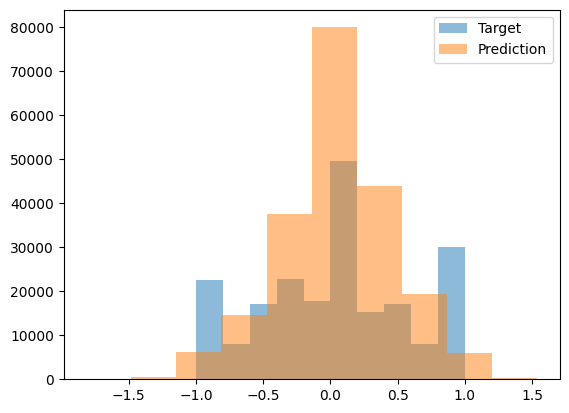

In [12]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [13]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [14]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [15]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

***